In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from matplotlib import rcParams
from cycler import cycler

In [47]:
## Set plotting style and print options
sns.set_theme()
sns.set_style("white")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.titlesize': 20,\
          'figure.labelsize': 18,'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
data_path = 'data/oecd_health_data.csv'
data_path_meds = 'data/diabetes_meds_consumption.csv'
data_path_death_rates = 'data/death_rate_from_diabetes_who.csv'
data_path_death_rates_standardized = 'data/death_rate_from_diabetes_age_standardized.csv'
data_path_prevalence = 'data/diabetes_prevalence.csv'

df = pd.read_csv(data_path)
df_meds = pd.read_csv(data_path_meds)
df_death_rates = pd.read_csv(data_path_death_rates).drop(columns=['Entity'])
df_death_rates_standardized = pd.read_csv(data_path_death_rates_standardized).drop(columns=['Entity'])
df_prevalence = pd.read_csv(data_path_prevalence).drop(columns=['Entity'])

df_death_rates_standardized['Measure'] = 'Death rate from diabetes (age standardized)'
df_death_rates['Measure'] = 'Death rate from diabetes'
df_prevalence['Measure'] = 'Prevalence of diabetes'

# rename columns Entity: REF_AREA, Year: TIME_PERIOD, Deaths -: OBS_VALUE
df_death_rates.rename(columns={'Code': 'REF_AREA', 'Year': 'TIME_PERIOD',\
                     f'{df_death_rates.columns[2]}': 'OBS_VALUE'}, inplace=True)
df_death_rates_standardized.rename(columns={'Code': 'REF_AREA', 'Year': 'TIME_PERIOD',\
                     f'{df_death_rates_standardized.columns[2]}': 'OBS_VALUE'}, inplace=True)
df_prevalence.rename(columns={'Code': 'REF_AREA', 'Year': 'TIME_PERIOD',\
                     f'{df_prevalence.columns[2]}': 'OBS_VALUE'}, inplace=True)

keep_cols = ['REF_AREA', 'Measure', 'OBS_VALUE', 'TIME_PERIOD']

# concatenate dataframes
df_res = pd.concat([df[keep_cols], df_meds[keep_cols], \
                df_death_rates, df_death_rates_standardized, df_prevalence], axis=0)

# Drop rows with NaN values
df_res.dropna(inplace=True)
# save to csv
df_res.to_csv('data/oecd_health_data_cleaned_merged.csv', index=False)

In [3]:
year_list = df_res['TIME_PERIOD'].unique()
year_list.sort()
Nyears = len(year_list)
country_list = df_res['REF_AREA'].unique()
country_list.sort()
Ncountries = len(country_list)

measure_list = df_res['Measure'].unique()
measure_list.sort()
Nmeasures = len(measure_list)

In [4]:
cols = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
num_cols = [18-24, 25-34, 35-44, 45-54, 55-64, 65-74, 75-100]
smartphone_percentile = [[96, 98, 94, 87, 71, 55, np.nan], [98, 98, 95, 95, 80, 62, np.nan],\
                                  [98, 98, 98, 95, 87, 65, np.nan], [100, 97, 97, 97, 89, 67, np.nan]]
smartphone_years = [2018, 2019, 2020, 2022]
vals_percentile = [25, 39.3, 49.7, 57.1, 62.7, 65.7, 59.3]
x = [vals_percentile]
x.extend(smartphone_percentile)
val_arr = np.array(x).T

columns=['Overweight % EU 2019']
for year in smartphone_years:
    columns.append(f'Smartphone % EU {year}')

df_age = pd.DataFrame(val_arr, cols, columns)

In [5]:

eu_hist = pd.read_csv('data/EUROPE-2020.csv').loc[4:]
eu_hist['T'] = eu_hist['M'] + eu_hist['F']

tot_vals = [eu_hist['T'].to_list()[0]]
for i in range(1, 10, 2):
    tot_vals.append(eu_hist['T'].values[i] + eu_hist['T'].values[i + 1])
tot_vals.append(eu_hist['T'].values[11:].sum())

val_arr = np.array([cols, tot_vals]).T
df_hist = pd.DataFrame(val_arr, columns=['Age', 'Population'])
df_hist['Population'] = df_hist['Population'].astype(int)
df_age['Population EU'] = pd.DataFrame(tot_vals, cols, columns=['Population EU'])


In [38]:
int(cols[0][-2:]), int(cols[0][:2])
est_centers = [int(cols[i][:2]) + int((float(cols[i][-2:]) - float(cols[i][:2])) / 2) for i in range(len(cols)-1)]
est_centers.append(75 + 5)
est_vals = np.linspace(21,80,100)
est_vals_smart = np.linspace(21,69,100)
f_cubic = interp1d(est_centers, df_age['Overweight % EU 2019'].values, kind = 'cubic')
f_smart = interp1d(est_centers[:-1], df_age['Smartphone % EU 2020'].values[:-1], kind = 'cubic')
preds = f_cubic(est_vals)
smart_preds = f_smart(est_vals_smart)


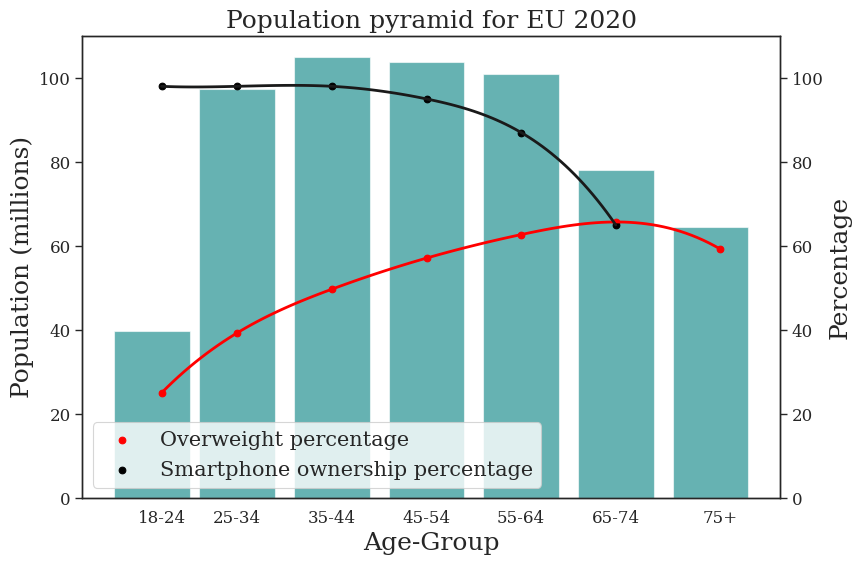

In [69]:
fig, ax = plt.subplots(figsize=(9, 6))
axx = ax.twinx()
ax.grid(False)
axx.grid(False)

est_centers_shift = est_centers.copy()
est_centers_shift[0] = 20
est_centers_shift[-1] = 79

data = {f'{cols[i]}': tot_vals[i] / 1_000_000 for i in range(len(cols))}
#ax.bar(list(data.keys()), list(data.values()))
ax.bar(est_centers_shift, df_age['Population EU'].values / 1_000_000, color='teal', width=8, alpha=.6,)
axx.scatter(est_centers, df_age['Overweight % EU 2019'], color='red', label = 'Overweight percentage')
axx.scatter(est_centers, df_age['Smartphone % EU 2020'], color='black', label = 'Smartphone ownership percentage')
axx.plot(est_vals, preds, '-', color='red')
axx.plot(est_vals_smart, smart_preds, 'k-')
ax.set_xticks(est_centers, cols)
axx.set_ylabel('Percentage')
ax.set_ylim(0, 110)
axx.set_ylim(0, 110)


ax.set(ylabel="Population (millions)", xlabel="Age-Group", title = "Population pyramid for EU 2020")
axx.legend()
fig.savefig('figs/pop_pyram.svg', dpi=420, bbox_inches='tight', transparent=True)

In [12]:
def func(x, a, b):
    return a * np.exp(b * x)
year = [ 2016, 2017, 2018, 2019, 2020, 2021, 2022]
years_predict = year + [2023,2024,2025]
users = [126, 165, 255, 315, 366, 457, 560] # 79
df_healthapp = pd.DataFrame(year, users, columns=['Health app users (annual)'])

In [13]:
popt, pcov = curve_fit(func, np.arange(len(year)), users)
prediction = func(np.arange(len(years_predict)), *popt)
prediction_lower = func(np.arange(len(years_predict)), *popt - np.sqrt(np.diag(pcov)))
prediction_upper = func(np.arange(len(years_predict)), *popt + np.sqrt(np.diag(pcov)))

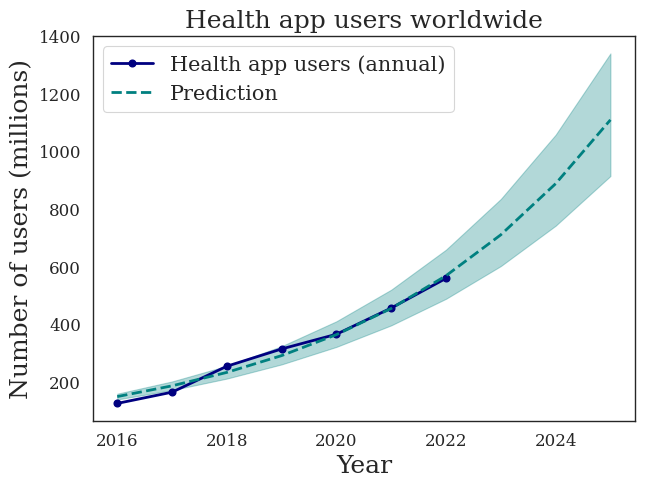

In [68]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(year, users, marker='o', linestyle='-', color='navy', label='Health app users (annual)')
ax.plot(years_predict, func(np.arange(len(years_predict)), *popt), linestyle='--', color='teal', label='Prediction')
#ax.fill_between(years_predict[len(year) - 1:], prediction_lower[len(year) - 1:], \
#                prediction_upper[len(year) - 1:], color='teal', alpha=0.3, label='Prediction interval')
ax.fill_between(years_predict[:], prediction_lower[:], \
                prediction_upper[:], color='teal', alpha=0.3, )
ax.set_xlabel('Year', fontweight='normal')
ax.set_ylabel('Number of users (millions)')
ax.set_title('Health app users worldwide')
ax.legend(loc='upper left')
fig.savefig('figs/health_app.svg', dpi=420, bbox_inches='tight', transparent=True)

In [15]:
inf_share22 = 16.5 # in B usd
ann_growth_rate = 0.286
years = np.arange(2022, 2033)
predictions = inf_share22 * (1 + ann_growth_rate)**(years - 2022)

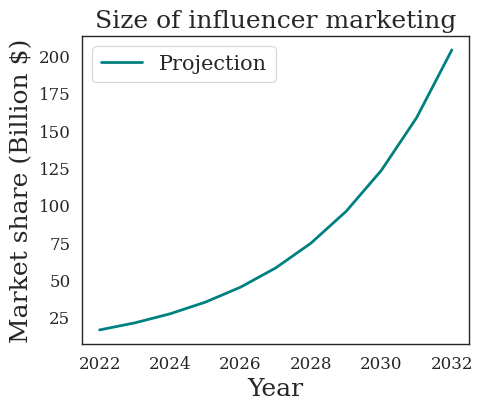

In [67]:
fig, ax = plt.subplots(figsize = (5,4))
ax.plot(years, predictions, label='Projection')
ax.set_xlabel('Year')
ax.set_ylabel('Market share (Billion $)')
ax.set_title('Size of influencer marketing')
ax.legend(loc='upper left')
fig.savefig('figs/influencer_market_share.svg', dpi=420, bbox_inches='tight', transparent=True)